In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
print("슝=3")

슝=3


#1.model

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

  def compute_output_shape(self, input_shape):
    return input_shape

print("슝=3")

슝=3


In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query,batch_size)
    key = self.split_heads(key,batch_size)
    value = self.split_heads(value,batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [244]:
class MultiHeadAttention2(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention2, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size, seq_len):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, seq_len, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 3, 1, 2, 4])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]
    #seq_len=tf.shape(query)[1]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query,batch_size,tf.shape(query)[1])
    key = self.split_heads(key,batch_size,tf.shape(key)[1])
    value = self.split_heads(value,batch_size,tf.shape(value)[1])

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 3, 1, 4])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, seq_len, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [5]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [6]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [183]:
def create_diag_mask(x):
  batch=tf.shape(x)[0]
  seq_len = tf.shape(x)[1]
  diag = tf.eye(num_rows=seq_len, num_columns=seq_len)  # (C, S)
  diag = tf.repeat(diag[tf.newaxis,:,:], repeats=batch , axis=0)
  return diag[:, :, :, tf.newaxis] # (B, S, S, D)

In [59]:
def create_real_mask2(x):
  seq_len = tf.shape(x)[1]
  #x=x[0:1]
  real_mask_list=[]
  pad=create_padding_mask(x)
  for i in range(seq_len):
    mask=1-tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0)
    row_mask = tf.concat([tf.zeros((seq_len, i+1)),tf.ones((seq_len, seq_len-(i+1)))], axis=1)

    full_mask = tf.multiply(mask, row_mask)
    mask=tf.maximum(full_mask,pad)
    real_mask_list.append(mask)
  real_mask = tf.concat(real_mask_list, axis=1)
  real_mask= real_mask[:,:, tf.newaxis, :, :]
  # real_mask = tf.reshape(-1,seq_len,1,seq_len,seq_len)
  return real_mask

In [217]:
def create_real_mask(x):
  batch_size = tf.shape(x)[0]
  seq_len = tf.shape(x)[1]

  pad_mask = create_padding_mask(x) # (B,1,1,S)
  causal_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) # (S,S)

  col_idx = tf.range(seq_len)[tf.newaxis, :]
  mask_step = tf.range(1, seq_len + 1)[:, tf.newaxis]
  base_mask = tf.cast(col_idx >= mask_step, tf.float32)  # (S,S)
  masks = tf.repeat(base_mask[:, tf.newaxis, :], repeats=seq_len, axis=1) # (S,S,S)

  full_mask = tf.multiply(causal_mask[tf.newaxis,:,:], masks)  # (S,S,S)

  full_mask = tf.repeat(full_mask[tf.newaxis,:,:,:], repeats=batch_size , axis=0) # (B,S,S,S)

  real_mask = tf.maximum(full_mask, pad_mask) # (B,S,S,S)



  return real_mask[:,tf.newaxis,:,:,:]

##1.2 mask test

In [5]:
test=tf.constant([[ 1,  2,  3,  4,  5],    # 배치 1: 패딩 없음
       [ 6,  7,  8,  9,  0],    # 배치 2: 마지막 1개 패딩
       [10, 11, 12,  0,  0]])   # 배치 3: 마지막 2개 패딩

In [101]:
seq_len=tf.shape(test)[1]

In [108]:
col_idx = tf.range(seq_len)[tf.newaxis, :]  # (1, S)
# mask index per context step: shape (S, 1)
mask_step = tf.range(1, seq_len + 1)[:, tf.newaxis]  # (S, 1)

# Broadcast: col_idx < step
# 각 i에 대해 col < i 이면 0, else 1
base_mask = tf.cast(col_idx >= mask_step, tf.float32)  # (S, S)
masks = tf.repeat(base_mask[:, tf.newaxis, :], repeats=seq_len, axis=1)

In [115]:
print(base_mask[:,tf.newaxis,:])

tf.Tensor(
[[[0. 1. 1. 1. 1.]]

 [[0. 0. 1. 1. 1.]]

 [[0. 0. 0. 1. 1.]]

 [[0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 0.]]], shape=(5, 1, 5), dtype=float32)


In [113]:
seq_len=tf.shape(test)[1]
pad=create_padding_mask(test)

In [142]:
mask=1-tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0)

In [112]:
row_mask= tf.concat([tf.zeros((seq_len, 5)),tf.ones((seq_len, seq_len-5))], axis=1)

In [168]:
mask2=tf.multiply(mask,row_mask)

In [113]:
print(row_mask)

tf.Tensor(
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)


In [156]:
print(mask)

tf.Tensor(
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)


In [169]:
print(mask2)

tf.Tensor(
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)


In [10]:
print(create_real_mask(test))

tf.Tensor(
[[[[[0. 1. 1. 1. 1.]
    [0. 0. 1. 1. 1.]
    [0. 0. 0. 1. 1.]
    [0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 0.]]]


  [[[0. 0. 1. 1. 1.]
    [0. 0. 1. 1. 1.]
    [0. 0. 0. 1. 1.]
    [0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 0.]]]


  [[[0. 0. 0. 1. 1.]
    [0. 0. 0. 1. 1.]
    [0. 0. 0. 1. 1.]
    [0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 0.]]]


  [[[0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 0.]]]


  [[[0. 0. 0. 0. 0.]
    [0. 0. 0. 0. 0.]
    [0. 0. 0. 0. 0.]
    [0. 0. 0. 0. 0.]
    [0. 0. 0. 0. 0.]]]]



 [[[[0. 1. 1. 1. 1.]
    [0. 0. 1. 1. 1.]
    [0. 0. 0. 1. 1.]
    [0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 1.]]]


  [[[0. 0. 1. 1. 1.]
    [0. 0. 1. 1. 1.]
    [0. 0. 0. 1. 1.]
    [0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 1.]]]


  [[[0. 0. 0. 1. 1.]
    [0. 0. 0. 1. 1.]
    [0. 0. 0. 1. 1.]
    [0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 1.]]]


  [[[0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 1.]
    [0. 0. 0. 0. 1.]]]


  [[[0

#2.model build

In [7]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [8]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [9]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs2 = tf.keras.Input(shape=(None, None, d_model), name="inputs2")
  enc_outputs = tf.keras.Input(shape=(None, None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1 ,1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention2(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs2,
          'key': inputs2,
          'value': inputs2,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs2)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention2(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs2, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [10]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None, None), name='look_ahead_mask')

  #inputs = tf.keras.layers.Lambda(lambda x: tf.sparse.to_dense(x))(inputs)
  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  enc_outputs2 = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(enc_outputs)
  enc_outputs2 = tf.keras.layers.Lambda(lambda x : tf.repeat(x, repeats=tf.shape(x)[2], axis=1))(enc_outputs2)
  padding_mask2 = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(padding_mask)
  outputs2 = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(outputs)
  outputs2 = tf.keras.layers.Lambda(lambda x: tf.repeat(x, repeats=tf.shape(x)[2], axis=1))(outputs2)
  diag_mask = tf.keras.layers.Lambda(create_diag_mask)(outputs2)
  for i in range(num_layers):

    # if i >= 1:
    #   outputs = tf.keras.layers.Lambda(lambda x : tf.multiply(x[0], x[1]),output_shape=(None,None,d_model))([diag_mask,outputs])
    outputs2 = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs2, enc_outputs2, look_ahead_mask, padding_mask2])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs2,
      name=name)
print("슝=3")

슝=3


##2.1 제출용

In [9]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layeraa(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [10]:
def decoderaa(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            max_len,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(max_len, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layeraa(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


#3.데이터 전처리

In [11]:
import pandas as pd

In [32]:
data=pd.read_csv('ChatbotData.csv')

In [33]:
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [34]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence).lower()

  sentence = re.sub(r'[^가-힣a-zA-Z0-9.,?!\s]', ' ', sentence)
  sentence = re.sub(r'\s+', " ", sentence)
  sentence = re.sub(r'^\s+|\s+$', '', sentence)

  return sentence
print("슝=3")

슝=3


In [69]:
preprocess_sentence(data['A'][0])

'하루가 또 가네요 .'

In [35]:
data['A_']=data['A'].apply(preprocess_sentence)
data['Q_']=data['Q'].apply(preprocess_sentence)

inputs=np.array(data['Q_'])
outputs=np.array(data['A_'])

In [36]:
print(len(inputs))
print(len(outputs))

11823
11823


#4.tokenizer

In [37]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(inputs + outputs, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [38]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [83]:
lens=[]
for i in range(len(inputs)):
  lens.append(len(tokenizer.encode(inputs[i])))

print(np.array(lens).mean())

5.481265330288421


<Axes: ylabel='Density'>

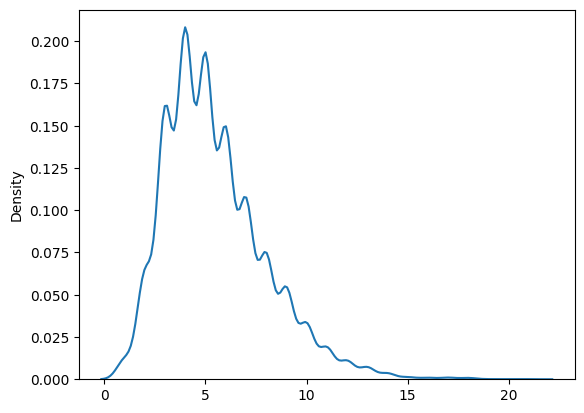

In [84]:
import seaborn as sns

sns.kdeplot(lens)

In [80]:
lens=[]
for i in range(len(outputs)):
  lens.append(len(tokenizer.encode(outputs[i])))

print(np.array(lens).mean())

5.826609151653557


In [39]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8359


In [40]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 17
print(MAX_LENGTH)

17


In [49]:
tokenizer.encode(inputs[1])

[8150, 51, 914, 8133, 988, 1711]

In [41]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [51]:
answers

array([[8357, 3845,   72, ...,    0,    0,    0],
       [8357, 1829, 5540, ...,    0,    0,    0],
       [8357, 3388,  770, ...,    0,    0,    0],
       ...,
       [8357, 5255,  271, ...,    0,    0,    0],
       [8357,   15, 3190, ...,    0,    0,    0],
       [8357,  204,  545, ...,    0,    0,    0]], dtype=int32)

In [42]:
questions, answers = tokenize_and_filter(inputs, outputs)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8359
필터링 후의 질문 샘플 개수: 11723
필터링 후의 답변 샘플 개수: 11723


In [49]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [67]:
questions

array([[8357, 8096, 1535, ...,    0,    0,    0],
       [8357, 8150,   51, ...,    0,    0,    0],
       [8357, 8152, 1428, ...,    0,    0,    0],
       ...,
       [8357, 8338, 8258, ...,    0,    0,    0],
       [8357,  137,  165, ...,    0,    0,    0],
       [8357, 1951,  878, ...,    0,    0,    0]], dtype=int32)

#4.train

In [43]:
def transformeraa(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                max_len,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoderaa(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
      max_len=max_len
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [219]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_real_mask,
      output_shape=(1, None, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  final_outputs = tf.keras.layers.Lambda(lambda x: tf.linalg.diag_part(x),output_shape=(None, d_model))(dec_outputs)
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(final_outputs)


  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [32]:
VOCAB_SIZE

8359

In [44]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model = transformeraa(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_len=MAX_LENGTH)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3194112     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [39]:
MAX_LENGTH

17

In [53]:
answers = np.array(answers, dtype=np.int32)

In [45]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [46]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


In [59]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [47]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [238]:
dataset

<_PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 17), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 16), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 16), dtype=tf.int32, name=None)})>

In [46]:
for x, y in dataset.take(90):
    print(x)
    print(y)

{'inputs': <tf.Tensor: shape=(64, 17), dtype=int32, numpy=
array([[8357, 8337, 8252, ...,    0,    0,    0],
       [8357, 1692,  186, ...,    0,    0,    0],
       [8357, 6620,  123, ...,    0,    0,    0],
       ...,
       [8357, 1755, 6214, ...,    0,    0,    0],
       [8357, 1821,   13, ...,    0,    0,    0],
       [8357, 6665, 7131, ...,    0,    0,    0]], dtype=int32)>, 'dec_inputs': <tf.Tensor: shape=(64, 16), dtype=int32, numpy=
array([[8357, 7257,    4, ...,    0,    0,    0],
       [8357, 2487, 6246, ...,    0,    0,    0],
       [8357,  664,  402, ...,    0,    0,    0],
       ...,
       [8357,   70, 7373, ...,    0,    0,    0],
       [8357,  601, 3752, ...,    0,    0,    0],
       [8357,  831,  213, ...,    0,    0,    0]], dtype=int32)>}
{'outputs': <tf.Tensor: shape=(64, 16), dtype=int32, numpy=
array([[7257,    4,  214, ...,    0,    0,    0],
       [2487, 6246,    1, ...,    0,    0,    0],
       [ 664,  402, 6820, ...,    0,    0,    0],
       ...,
 

In [50]:
EPOCHS = 20
history=model.fit(dataset, epochs=20, verbose=1)

Epoch 1/20
184/184 [==============================] - 32s 38ms/step - loss: 3.5136 - accuracy: 0.0545
Epoch 2/20
184/184 [==============================] - 7s 37ms/step - loss: 2.8574 - accuracy: 0.1178
Epoch 3/20
184/184 [==============================] - 7s 36ms/step - loss: 2.4636 - accuracy: 0.1223
Epoch 4/20
184/184 [==============================] - 7s 37ms/step - loss: 2.2837 - accuracy: 0.1284
Epoch 5/20
184/184 [==============================] - 7s 37ms/step - loss: 2.1581 - accuracy: 0.1362
Epoch 6/20
184/184 [==============================] - 7s 37ms/step - loss: 2.0405 - accuracy: 0.1435
Epoch 7/20
184/184 [==============================] - 7s 37ms/step - loss: 1.9134 - accuracy: 0.1523
Epoch 8/20
184/184 [==============================] - 7s 37ms/step - loss: 1.7739 - accuracy: 0.1645
Epoch 9/20
184/184 [==============================] - 7s 37ms/step - loss: 1.6240 - accuracy: 0.1791
Epoch 10/20
184/184 [==============================] - 7s 37ms/step - loss: 1.4655 - accur

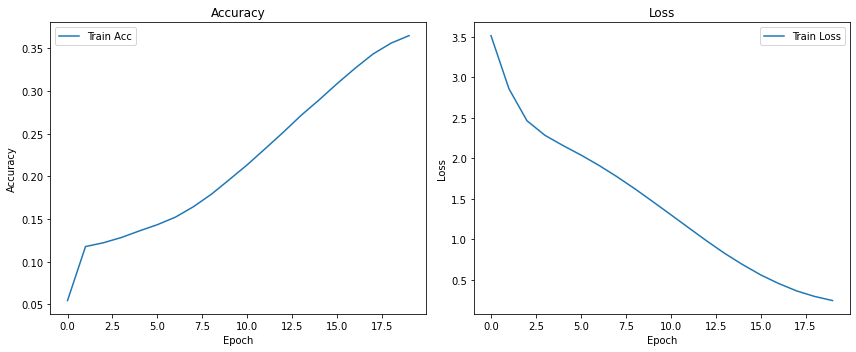

In [51]:
import matplotlib.pyplot as plt

# history에서 metric 추출
acc = history.history.get('accuracy')
loss = history.history.get('loss')


# plot
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#5.inference

In [52]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [53]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [54]:
sentence_generation('밥 먹었어?')

입력 : 밥 먹었어?
출력 : 저는 배터리가 밥이예요 .


'저는 배터리가 밥이예요 .'

In [55]:
sentence_generation('이제 주말이야')

입력 : 이제 주말이야
출력 : 혼자만의 시간이 많아지죠 .


'혼자만의 시간이 많아지죠 .'